# Hw 1-2

# Import libraries

In [ ]:
# Import libraries
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from torch import nn
from torch.nn import functional as F
from torchvision import datasets, transforms

# Use Colab env

In [ ]:
# Use google colab environments
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check device: GPU(cuda) or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load dataset

In [ ]:
# dataset upload
# data augmentation
# data normalization
transform_train = transforms.Compose([ # train set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([ # validation set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


transform_test = transforms.Compose([ # test set loader
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_val)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# split the training set into training and validation sets
train_size = int(0.9 * len(train_set)) # use only 5000 images for validation
val_size = len(train_set) - train_size
train_set, valset = torch.utils.data.random_split(train_set, [train_size, val_size])

100%|██████████| 170M/170M [00:03<00:00, 46.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 128, shuffle=True) # use shuffle only for train
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
# sample image plot
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array([0.5, 0.5, 0.5] + np.array([0.5, 0.5, 0.5]))
  image = image.clip(0, 1)
  return image

In [ ]:
CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

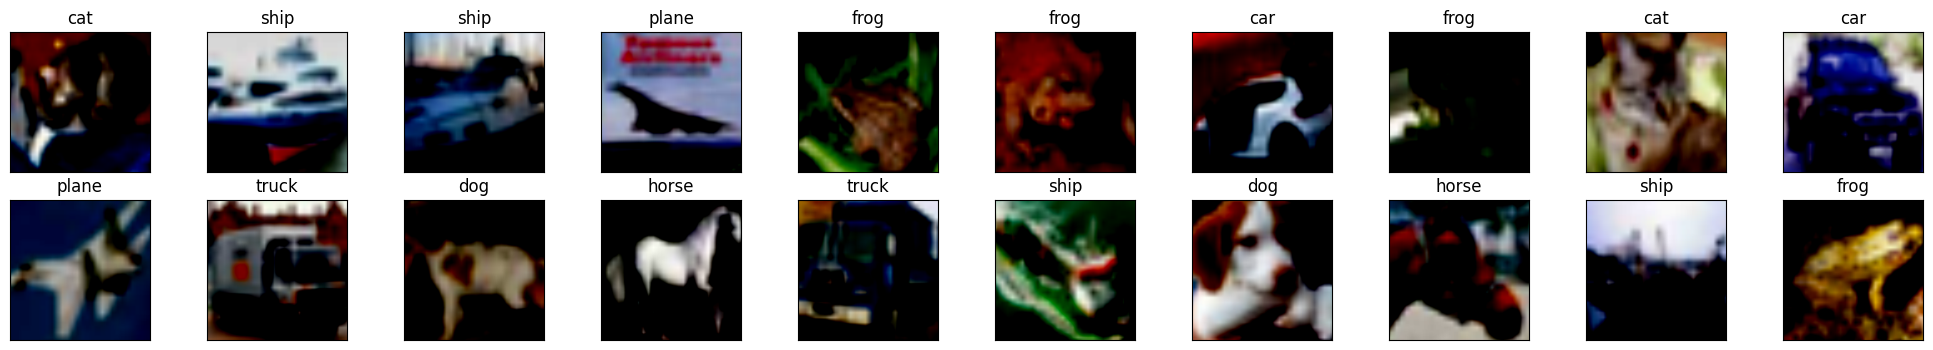

In [ ]:
# sample test image plot (normalized ones)
data_iter = iter(test_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(25, 4))

for i in np.arange(20): # normalized test images
  # row 2 column 10
  ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[i]))
  ax.set_title(CLASS_NAMES[labels[i].item()])

# Define AlexNet

In [ ]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the model and optimizer
model = AlexNet().to(device) # use adam
optimizer = optim.Adam(model.parameters(), lr=0.001) # set learning rate as 0.001

# Check structure of the model

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inp

# Train the model

In [ ]:
# Train the model
criterion = nn.CrossEntropyLoss()
num_epoch = 10
PATH =  "/content/drive/MyDrive/alexNet_pytorch.pt"
import math
total_batches = math.ceil(len(train_set) / 128)
total_steps = num_epoch * total_batches

In [ ]:
best_val_acc = 0.0  # initialize to lowest possible value
for epoch in range(num_epoch):
    # Train the model
    train_loss = 0.0
    train_acc = 0.0
    model.train()  # set model to training mode

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad() # zero out the gradients
        outputs = model(images) # forward pass
        loss = criterion(outputs, labels) # compute loss

        loss.backward() # backward pass
        optimizer.step() # update weights

        train_loss += loss.item() * images.size(0) # calculate training loss and accuracy
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

        if (i + 1) % 100 == 0: # print status update every 100 batches
            print(f'Epoch [{epoch+1}/{num_epoch}], Step [{i+1}/{total_steps}], '
                  f'Training Loss: {train_loss / ((i+1)*128):.4f}, Training Accuracy: {train_acc / ((i+1)*128):.4f}')

    # Validate the model
    val_loss = 0.0
    val_acc = 0.0
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            # Move images and labels to device (GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            # Calculate validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)

    # Calculate average losses and accuracies
    train_loss = train_loss / len(train_set)
    train_acc = train_acc / len(train_set)
    val_loss = val_loss / len(val_set)
    val_acc = val_acc / len(val_set)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epoch}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), PATH)

Epoch [1/10], Step [100/3520], Training Loss: 2.2228, Training Accuracy: 0.1899
Epoch [1/10], Step [200/3520], Training Loss: 2.0333, Training Accuracy: 0.2480
Epoch [1/10], Step [300/3520], Training Loss: 1.9116, Training Accuracy: 0.2920
Epoch [1/10], Training Loss: 1.8685, Training Accuracy: 0.3084, Validation Loss: 1.5184, Validation Accuracy: 0.4482
Epoch [2/10], Step [100/3520], Training Loss: 1.5057, Training Accuracy: 0.4602
Epoch [2/10], Step [200/3520], Training Loss: 1.4716, Training Accuracy: 0.4678
Epoch [2/10], Step [300/3520], Training Loss: 1.4540, Training Accuracy: 0.4707
Epoch [2/10], Training Loss: 1.4380, Training Accuracy: 0.4768, Validation Loss: 1.2344, Validation Accuracy: 0.5524
Epoch [3/10], Step [100/3520], Training Loss: 1.2951, Training Accuracy: 0.5354
Epoch [3/10], Step [200/3520], Training Loss: 1.2960, Training Accuracy: 0.5400
Epoch [3/10], Step [300/3520], Training Loss: 1.2880, Training Accuracy: 0.5404
Epoch [3/10], Training Loss: 1.2782, Training 

# Test the model

In [ ]:
# Evaluate the model on the test set
correct = 0
total = 0
test_model = AlexNet().to(device)
test_model.load_state_dict(torch.load(PATH))

start_time = time.time()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = test_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

end_time = time.time()
elapsed_time = end_time - start_time
avg_time_per_image = elapsed_time / total

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)) # accuracy for test images
print(f"Total inference time: {elapsed_time:.4f} seconds")
print(f"Average time per image: {avg_time_per_image * 1000:.4f} ms")
print(f"Inference speed: {1 / avg_time_per_image:.2f} images/second")

<ipython-input-37-ca729e7965cc>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(PATH))


Accuracy of the network on the 10000 test images: 68 %
Total inference time: 23.5124 seconds
Average time per image: 2.3512 ms
Inference speed: 425.31 images/second


# Student Model Training and Testing (From Scratch & Distilled)

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Student model
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),   # (3, 224, 224) → (16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # (16, 112, 112)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (32, 112, 112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # (32, 56, 56)
        )

        # 32 * 56 * 56 = 100352
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # (batch_size, 100352)
        x = self.classifier(x)
        return x

In [ ]:
# Train function for student model
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / total
        accuracy = correct / total
        print(f"[Standard] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")

In [ ]:
# Test function - wrap function calls with torch.no_grad()
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()  # Start timing

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    accuracy = 100 * correct / total
    avg_time_per_image = elapsed_time / total
    images_per_second = 1 / avg_time_per_image

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Total inference time: {elapsed_time:.4f} seconds")
    print(f"Average time per image: {avg_time_per_image * 1000:.4f} ms")
    print(f"Inference speed: {images_per_second:.2f} images/second")

    return accuracy, elapsed_time

In [ ]:
# Knowledge distillation function
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)
    teacher.eval()

    for epoch in range(epochs):
        student.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(images)

            student_logits = student(images)

            # Soft target loss (KL Divergence with temperature)
            soft_loss = F.kl_div(
                F.log_softmax(student_logits / T, dim=1),
                F.softmax(teacher_logits / T, dim=1),
                reduction='batchmean'
            ) * (T ** 2)

            # CE loss with true labels
            label_loss = ce_loss(student_logits, labels)

            loss = soft_target_loss_weight * soft_loss + ce_loss_weight * label_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = student_logits.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / total
        accuracy = correct / total
        print(f"[KD] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")

In [ ]:
teacher_model = AlexNet().to(device)
teacher_model.load_state_dict(torch.load(PATH))
teacher_model.eval()  # Freeze teacher model for distillation


<ipython-input-23-9fffc332f76e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load(PATH))


In [ ]:
# Test teacher model
test_accuracy_deep = test(teacher_model, test_loader, device)

Accuracy: 71.51%
Total inference time: 23.8994 seconds
Average time per image: 2.3899 ms
Inference speed: 418.42 images/second


In [ ]:
# Train student from scratch
student_model = LightNN(num_classes=10).to(device)
train(student_model, train_loader, epochs=10, learning_rate=0.001, device=device)

[Standard] Epoch 1/10 - Loss: 1.6321 - Accuracy: 0.4195
[Standard] Epoch 2/10 - Loss: 1.3510 - Accuracy: 0.5201
[Standard] Epoch 3/10 - Loss: 1.2104 - Accuracy: 0.5697
[Standard] Epoch 4/10 - Loss: 1.1166 - Accuracy: 0.6017
[Standard] Epoch 5/10 - Loss: 1.0405 - Accuracy: 0.6299
[Standard] Epoch 6/10 - Loss: 0.9805 - Accuracy: 0.6526
[Standard] Epoch 7/10 - Loss: 0.9079 - Accuracy: 0.6771
[Standard] Epoch 8/10 - Loss: 0.8593 - Accuracy: 0.6948
[Standard] Epoch 9/10 - Loss: 0.7853 - Accuracy: 0.7255
[Standard] Epoch 10/10 - Loss: 0.7229 - Accuracy: 0.7453


In [ ]:
# Test student from scratch
test_accuracy_light_ce = test(student_model, test_loader, device)

Accuracy: 60.37%
Total inference time: 23.3891 seconds
Average time per image: 2.3389 ms
Inference speed: 427.55 images/second


In [ ]:
# Train student with knowledge distillation
distilled_model = LightNN(num_classes=10).to(device) # For KD training
train_knowledge_distillation(teacher=teacher_model, student=distilled_model, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)

[KD] Epoch 1/10 - Loss: 1.7764 - Accuracy: 0.4259
[KD] Epoch 2/10 - Loss: 1.3906 - Accuracy: 0.5235
[KD] Epoch 3/10 - Loss: 1.2697 - Accuracy: 0.5637
[KD] Epoch 4/10 - Loss: 1.1530 - Accuracy: 0.6008
[KD] Epoch 5/10 - Loss: 1.0563 - Accuracy: 0.6370
[KD] Epoch 6/10 - Loss: 0.9727 - Accuracy: 0.6686
[KD] Epoch 7/10 - Loss: 0.8985 - Accuracy: 0.6995
[KD] Epoch 8/10 - Loss: 0.8409 - Accuracy: 0.7279
[KD] Epoch 9/10 - Loss: 0.7628 - Accuracy: 0.7609
[KD] Epoch 10/10 - Loss: 0.7034 - Accuracy: 0.7911


In [ ]:
# Test student with knowledge distillation
test_accuracy_light_ce_and_kd = test(distilled_model, test_loader, device)

Accuracy: 63.07%
Total inference time: 21.9342 seconds
Average time per image: 2.1934 ms
Inference speed: 455.91 images/second


In [ ]:
# Compare
print(f"Teacher accuracy and inference time (AlexNet):        {test_accuracy_deep}")
print(f"Student accuracy and inference time (from scratch):   {test_accuracy_light_ce}")
print(f"Student accuracy and inference time (with KD):        {test_accuracy_light_ce_and_kd} \n")

# Model parameter counts
print(f"Teacher (AlexNet) parameters:      {sum(p.numel() for p in teacher_model.parameters()):,}")
print(f"Student parameters:                {sum(p.numel() for p in student_model.parameters()):,} \n")

# Norm of 1st layer of initial lightweight model & new lightweight model
print("Norm of 1st layer of student_model:",     torch.norm(student_model.features[0].weight).item())
print("Norm of 1st layer of distilled_model:",   torch.norm(distilled_model.features[0].weight).item())

Teacher accuracy and inference time (AlexNet):        (71.51, 23.899423360824585)
Student accuracy and inference time (from scratch):   (60.37, 23.389117002487183)
Student accuracy and inference time (with KD):        (63.07, 21.93422794342041) 

Teacher (AlexNet) parameters:      58,322,314
Student parameters:                25,698,026 

Norm of 1st layer of student_model: 2.6252965927124023
Norm of 1st layer of distilled_model: 2.578221082687378


# Sample image plot

In [ ]:
# Function to plot images along with their predictions
def plot_predictions(images, labels, predictions):
    fig, axs = plt.subplots(1, len(images), figsize=(25, 4))
    for i in range(len(images)):
        image = images[i] / 2 + 0.5     # Unnormalize the image
        image = image.permute(1, 2, 0)   # Transpose to (height, width, channels)
        axs[i].imshow(image)
        axs[i].set_title(f"True: {CLASS_NAMES[labels[i]]}\nPred: {CLASS_NAMES[predictions[i]]}")
        axs[i].axis('off')
    plt.show()

In [ ]:
# Function to test a model and plot predictions
def test_and_plot_predictions(model, test_loader, device, num_images=10):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    images, labels = images.to(device), labels.to(device)
    sample_images = images[:num_images]
    sample_labels = labels[:num_images]

    with torch.no_grad():
        outputs = model(sample_images)
        _, predicted = torch.max(outputs, 1)

    plot_predictions(sample_images.cpu(), sample_labels.cpu(), predicted.cpu())

## Teacher Model

Teacher Model Predictions:


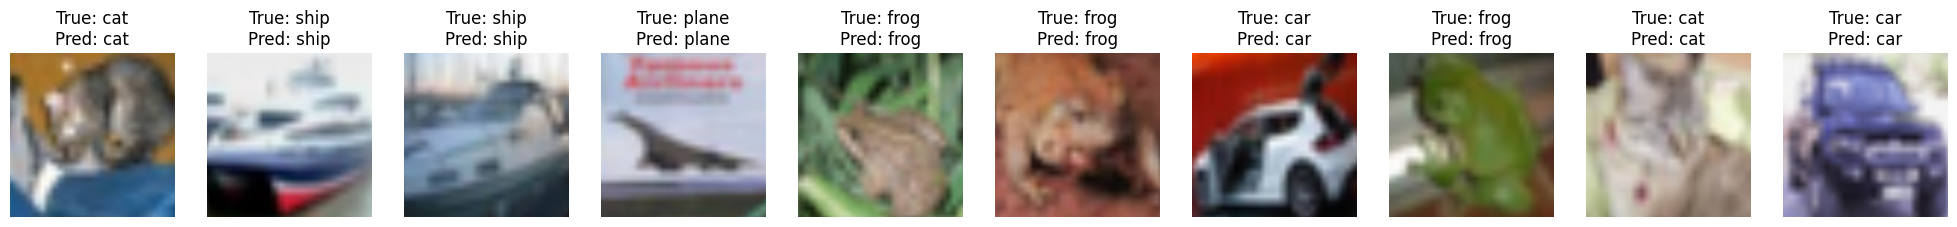

In [ ]:
print("Teacher Model Predictions:")
test_and_plot_predictions(teacher_model, test_loader, device)

## Student Model (Distilled)

Distilled Student Model Predictions:


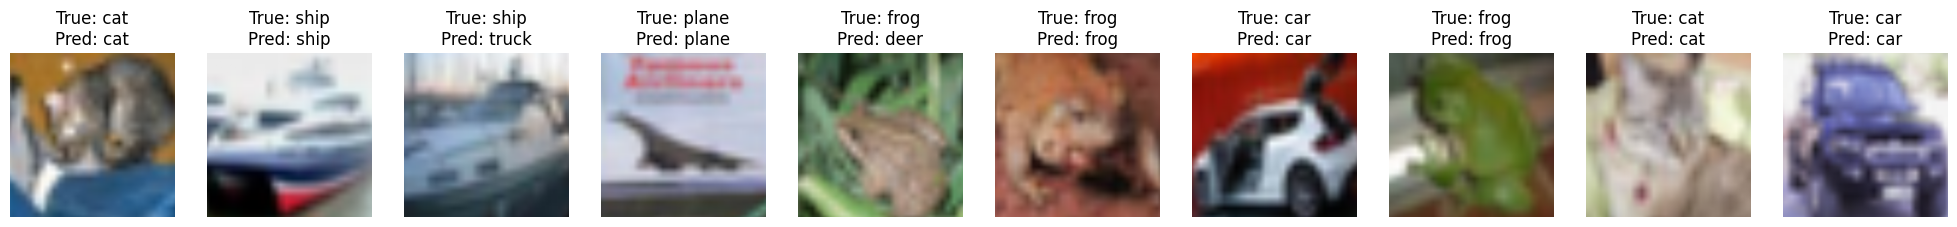

In [ ]:
print("Distilled Student Model Predictions:")
test_and_plot_predictions(distilled_model, test_loader, device)

## Teacher Model vs. Distilled Student Model



---


Teacher accuracy (AlexNet):              71.51% <br>
Teacher inference time (AlexNet):        23.8994 seconds <br>


---


Student accuracy (from scratch):         60.37% <br>
Student inference time (from scratch):   23.3891 seconds <br>


---


Student accuracy (with KD):              63.07% <br>
Student inference time (with KD):        21.9342 seconds


---

